# Data Science Immersive - General Assembly 
## Tale of Two Cities - Capstone Project
Harsha Goonewardana 
16th July 2017

## I. Overview and motivation 

### Motivation

I am perticularly interested in the dynamics of the  real estate market markets in the USA , especially with the pricing structure around short-term rentals.

I treated this very noisy dataset as an opportunity to look for patterns and deploy various regression, clstering and natural language processing tools.

Most data science problems do not come in neatly demarcared training and test sets. A good data scientist should be able to apply a variety of data science techniques to gain domain knowledge.  


### Project Overview

Airbnb is a peer to peer accommodation rental platform with 5 million listing across 191+ countries. The platform has more rooms available at a given time than top five hotel chains combined n 2018 . This project aims to first determine the feature importance of a number of variables to the rental yield followed by a deployment of a model to predict rental yields or prices.


### Other Studies 

#### Feature selection
While there have been a number of studies on the impact of Airbnb on property values and community cohesion, the literature on determinant of Airbnb yields are sparse. A review of the literature notes that property amenities, location, rental rules and review ratings have been identified as significant determinates of Airbnb prices  . Others have shown that geographical features such as distance to host city attractions and transit access. 

#### Yield as a dependent variable 
While academic research uses the listing price as the dependent variable, the approach is inadequate to capture the equilibrium price at which the transaction is made. As the supply and demand cycle needs to adjust over time , the supply-side variable necessitates the  presence of a tuning parameter. A new feature incorporating occupancy rate (estimated using length of stay and reviews) and listing price mitigates these issues and provides a more accurate measure of yield. 


### Problem Statement

This project will identify the features which have the most statistical significance on determining property values. Within that frame, the project will further isolate the significance of descriptive, geo-spatial and other features to understand the influence of each category. 

A variety of predictive and inference based models  will be deployed to understand feature importance and identify factors which have the most influence on pricing decisions by hosts. 


### Metrics

Mean squared error is used as the measure for model accuracy.  This measures the average of the square of the errors between the actual yield and predicted yield. The formula for this is as follows:

<img src="mse.svg">

The sqrt of MSE will be used as a measure fo how far teh predictions are from the actual value.

## Data Set

Following the lead from number of researchers in the field, the project uses the dataset from insideairbnb.com for New York City. A number of article have considered Inside Airbnb data to be more accurate than official Airbnb data as there have been issues with the fidelity in of the official data the past.  

The Inside Airbnb dataset contains 47542 unique listing locations from on 20th January 2009 to 15 May 2018.There are 95 separate features in a variety of types and 18 have been selected for further examination (see Appendix I).
New York Transit Authority dataset contains the longitude and latitude of each metro station within New York and will provide the distance to the closest from each Airbnb rental location.

### Data Dictionary
To keep the model manageable and effective, I will focus on the following features:
    1. 'name': Listing header text for text mining.
    2. 'description': Listing description text for text mining.
    3. 'property_type': Type of property e.g. apartment, house etc.
    4. 'room_type': Type of room e.g. private, shared etc.
    5. 'accommodates': No. of people the listing can accommodate.
    6. 'bathrooms': No. of bathrooms.
    7. 'bedrooms': No. of bedrooms.
    8. 'beds': No. of beds.
    9. 'square_feet': Size of listing.
    10. 'price': Price of listing.
    11. 'cleaning_fee': Cleaning fee.
    12. 'guests_included': No. of guests included in the base price.
    13. 'extra_people': Price for extra guests not included in the base price.
    14. 'minimum_nights': Minimum no. of nights required for booking.
    15. 'availability_365': No. of nights the listing is available for booking. (Note: This is a 'leaking' feature as listings may be unavailable as it is already booked and leaks the popularity. However, this needs to be used for filtering part-time listings and will be removed at a later stage.)
    16. 'reviews_per_month': Average no. of reviews listing receives per month. Used to calculate yield.
    17. 'latitude': Latitude of listing.
    18. 'longitude': Longitude of listing.
    


In [1]:
import pandas as pd
import os
import re
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import display
pd.options.display.max_columns = None

from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
random_seed =42

In [2]:
from haversine import haversine

In [3]:
sns.set(style="ticks")
seed=42


In [4]:
#import Listing Datasets 
df = pd.read_csv('./data/airbnb_nyc.csv', header=0, index_col=0,low_memory=False)
print("Dataset has {} rows, {} columns.".format(*df.shape))

Dataset has 47542 rows, 95 columns.


In [5]:
#import Subway Datasets 
df_transit = pd.read_csv('./data/NYC_Transit_Subway_Entrance_And_Exit_Data.csv', header=0, index_col=0,low_memory=False)
print("Dataset has {} rows, {} columns.".format(*df_transit.shape))

Dataset has 1868 rows, 31 columns.


In [6]:
df.isnull().sum().sort_values(ascending=False).head(10)

host_acceptance_rate    47542
xl_picture_url          47542
medium_url              47542
thumbnail_url           47542
jurisdiction_names      47536
license                 47532
square_feet             47059
monthly_price           41394
weekly_price            39958
notes                   29221
dtype: int64

In [7]:
df.columns



Index(['listing_url', 'scrape_id', 'last_scraped', 'name', 'summary', 'space',
       'description', 'experiences_offered', 'neighborhood_overview', 'notes',
       'transit', 'access', 'interaction', 'house_rules', 'thumbnail_url',
       'medium_url', 'picture_url', 'xl_picture_url', 'host_id', 'host_url',
       'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'street',
       'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedr

#### Select a subset of features as the first level of dimensionality reduction

### Identify noisy data types

#### Missing Values###
price and cleaning_fees are dependant variables so any rows without these variables will be dropped.

the missing values in security deposit, cleaning fee features may mean that the value is zero. This was confirmed by launching the urls from a subset of listings with null cleaning values to confirm that the cleaning fee is indeed zero.

In [8]:
df.isnull().sum()

listing_url                             0
scrape_id                               0
last_scraped                            0
name                                   27
summary                              1327
space                               15016
description                            91
experiences_offered                     0
neighborhood_overview               19072
notes                               29221
transit                             17631
access                              19582
interaction                         20736
house_rules                         19076
thumbnail_url                       47542
medium_url                          47542
picture_url                             0
xl_picture_url                      47542
host_id                                 0
host_url                                0
host_name                              22
host_since                             22
host_location                         172
host_about                        

In [9]:
#attribution Ben Shaver 
import webbrowser
for i in range(5):
    url = df.sort_values(by='security_deposit', ascending=True).iloc[i]['listing_url']
    webbrowser.open(url)

In [10]:
#Keep selected features

keep = [
    'description','number_of_reviews', 
    'property_type', 'room_type', 'accommodates',
    'bathrooms', 'bedrooms', 'beds',
    'price', 'cleaning_fee', 'guests_included', 'extra_people', 
    'minimum_nights','security_deposit','amenities','house_rules',
    'host_since','host_is_superhost','cancellation_policy',
    'neighbourhood_cleansed', 'reviews_per_month', 'latitude', 'longitude', 'bed_type'
]
df = df[keep]
print("Dataset has {} rows, {} columns.".format(*df.shape))


Dataset has 47542 rows, 24 columns.


In [11]:
# a sample of listings with null values in the cleaning category showed that these do not have a cleaning fee listed
# therefore I filled the nan values with  0
df.dropna(subset=['reviews_per_month','price'],axis=0,inplace=True)
df.cleaning_fee.fillna(0,inplace=True)
df.host_is_superhost.fillna('t',inplace=True)
df.security_deposit.fillna(0,inplace=True)
df.host_since.dropna(inplace=True)

In [12]:
#Missing values imputer from https://gist.github.com/EricTing/7353d70198a3a09d1220

from sklearn.base import TransformerMixin

class DataFrameImputer(TransformerMixin):

    def __init__(self):
        """Impute missing values.

        Columns of dtype object are imputed with the most frequent value 
        in column.

        Columns of other types are imputed with mean of column.

        """
    def fit(self, X, y=None):

        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c].mean() for c in X],
            index=X.columns)

        return self

    def transform(self, X, y=None):
        return X.fillna(self.fill)

In [13]:
def identify_features():
    obs = df.select_dtypes(include=['object']).columns

    num = df.select_dtypes(include=[np.number]).columns

    print('There are {} categorical features'.format(len(obs)))
    print(obs)

    print('\n There are {} numerical features'.format(len(num)))
    return(obs,num)

In [14]:
identify_features()

There are 14 categorical features
Index(['description', 'property_type', 'room_type', 'price', 'cleaning_fee',
       'extra_people', 'security_deposit', 'amenities', 'house_rules',
       'host_since', 'host_is_superhost', 'cancellation_policy',
       'neighbourhood_cleansed', 'bed_type'],
      dtype='object')

 There are 10 numerical features


(Index(['description', 'property_type', 'room_type', 'price', 'cleaning_fee',
        'extra_people', 'security_deposit', 'amenities', 'house_rules',
        'host_since', 'host_is_superhost', 'cancellation_policy',
        'neighbourhood_cleansed', 'bed_type'],
       dtype='object'),
 Index(['number_of_reviews', 'accommodates', 'bathrooms', 'bedrooms', 'beds',
        'guests_included', 'minimum_nights', 'reviews_per_month', 'latitude',
        'longitude'],
       dtype='object'))

In [15]:
# Clean numeric fields
# price, cleaning fees, host response rate are miscategorized as categorical and needs to be reassigned 
df['price'] = df['price'].replace({'\$': '',',':''}, regex=True)
df['price']=df['price'].astype('float32')

df['extra_people'] = df['extra_people'].replace({'\$': '',',':''}, regex=True)
df['extra_people']=df['extra_people'].apply(pd.to_numeric, errors='coerce')

df['cleaning_fee'] = df['cleaning_fee'].replace({'\$': '',',':''}, regex=True)
df['cleaning_fee']=df['cleaning_fee'].astype('float32')

df['security_deposit'] = df['security_deposit'].replace({'\$': '',',':''}, regex=True)
df['security_deposit']=df['security_deposit'].astype('float32')

print("Dataset has {} rows, {} columns.".format(*df.shape))


identify_features()


Dataset has 37791 rows, 24 columns.
There are 10 categorical features
Index(['description', 'property_type', 'room_type', 'amenities', 'house_rules',
       'host_since', 'host_is_superhost', 'cancellation_policy',
       'neighbourhood_cleansed', 'bed_type'],
      dtype='object')

 There are 14 numerical features


(Index(['description', 'property_type', 'room_type', 'amenities', 'house_rules',
        'host_since', 'host_is_superhost', 'cancellation_policy',
        'neighbourhood_cleansed', 'bed_type'],
       dtype='object'),
 Index(['number_of_reviews', 'accommodates', 'bathrooms', 'bedrooms', 'beds',
        'price', 'cleaning_fee', 'guests_included', 'extra_people',
        'minimum_nights', 'security_deposit', 'reviews_per_month', 'latitude',
        'longitude'],
       dtype='object'))

In [16]:
df.reset_index(drop=True,inplace=True)


In [17]:
df.index

RangeIndex(start=0, stop=37791, step=1)

In [18]:
# Impute most frequent for categorical features
categorical_feats = df.select_dtypes(include=['object']).columns
df[categorical_feats] = DataFrameImputer().fit_transform(df[categorical_feats])

# Impute median for numerical features
num_feats = df.select_dtypes(include=[np.number]).columns
imp = Imputer(missing_values=np.nan, strategy='median', axis=0)
df[num_feats] = imp.fit_transform(df[num_feats])

print("Dataset has {} rows, {} columns.".format(*df.shape))

Dataset has 37791 rows, 24 columns.


## Feature Engineering

**Outlier detection and mitigation **

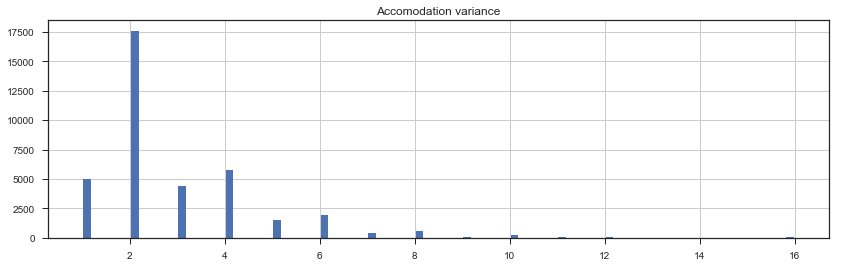

In [19]:
#Accomodation size
df.accommodates.hist(bins=75, rwidth=.8, figsize=(14,4))
plt.title('Accomodation variance')
plt.show()

Properties which can accomodate more than 10 people are similar to commercial accomodation providers than to private residences so are candidates for outlier removal 

/Users/admin/anaconda3/envs/dsi/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/admin/anaconda3/envs/dsi/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


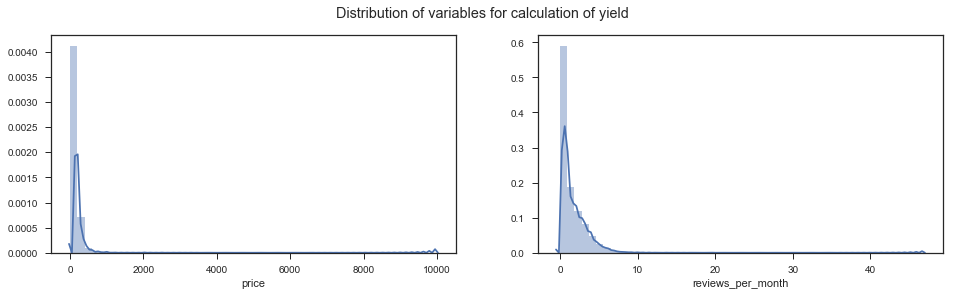

In [20]:
# analyse explanatory variables 
fig, axs = plt.subplots(ncols=2, figsize=(16, 4))
fig.suptitle('Distribution of variables for calculation of yield')
x_axis=df['price'].dropna()
sns.distplot(pd.Series(x_axis, name=x_axis.name), ax=axs[0])
x_axis=df['reviews_per_month'].dropna()
sns.distplot(pd.Series(x_axis, name=x_axis.name), ax=axs[1]);



Both these variables show high skew so are candidates for oulier removal techniques

#### Removing outliers in price and reviews per month
Relatively high rental prices and number of reviews were removed to mitigate the effects of very expensive properties and properties which have high turnover(e.g. commercial accomodation features)  which are atypical of a typical airbnb rental profile.

The top .1% of the price variable was removed to mitigate the influence of very high priced rentals 

Average reviews per month was capped to 30 days 

/Users/admin/anaconda3/envs/dsi/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/admin/anaconda3/envs/dsi/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Dataset has 37753 rows, 24 columns.


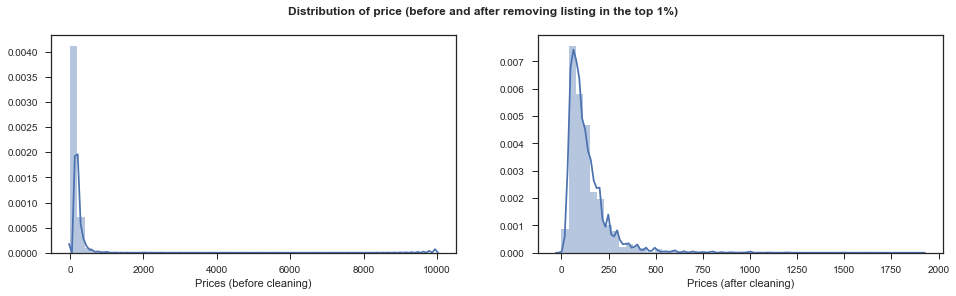

In [21]:
#attribution https://github.com/joaeechew
#Distribution of price
%matplotlib inline

fig, axs = plt.subplots(ncols=2, figsize=(16, 4))
fig.suptitle('Distribution of price (before and after removing listing in the top 1%)', weight='bold', fontsize=12)

# Before cleaning
x_axis=df['price'].dropna()
sns.distplot(pd.Series(x_axis, name='Prices (before cleaning)'), ax=axs[0])

# Remove where price > top 1%

p_out=df.price.quantile(.999)
df=df[df['price']<p_out]


print("Dataset has {} rows, {} columns.".format(*df.shape))

#After cleaning
x_axis=df['price'].dropna()
sns.distplot(pd.Series(x_axis, name='Prices (after cleaning)'), ax=axs[1]);

/Users/admin/anaconda3/envs/dsi/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/admin/anaconda3/envs/dsi/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


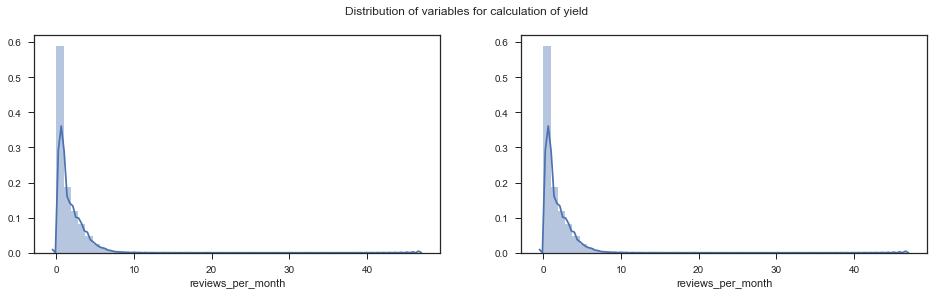

In [22]:
#Reexamine the explanatory variables for skew

# analyse explanatory variables 
fig, axs = plt.subplots(ncols=2, figsize=(16, 4))
fig.suptitle('Distribution of variables for calculation of yield')
x_axis=df['reviews_per_month'].dropna()
sns.distplot(pd.Series(x_axis, name=x_axis.name), ax=axs[0])
x_axis=df['reviews_per_month'].dropna()
sns.distplot(pd.Series(x_axis, name=x_axis.name), ax=axs[1]);


/Users/admin/anaconda3/envs/dsi/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/admin/anaconda3/envs/dsi/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Dataset has 37751 rows, 24 columns.


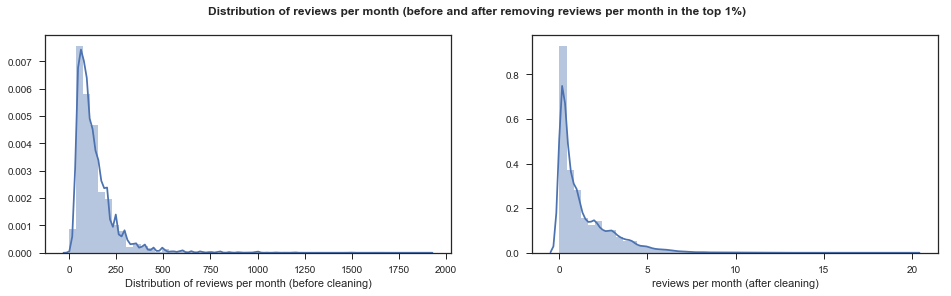

In [23]:
#Distribution of reviews per month
%matplotlib inline

fig, axs = plt.subplots(ncols=2, figsize=(16, 4))
fig.suptitle('Distribution of reviews per month (before and after removing reviews per month in the top 1%)', weight='bold', fontsize=12)

# Before cleaning
x_axis=df['price'].dropna()
sns.distplot(pd.Series(x_axis, name='Distribution of reviews per month (before cleaning)'), ax=axs[0])

# Remove where reviews per month> top 1%

p_p=30 # to remove listing with more reviews per month than days in a month 
df= df[df["reviews_per_month"]<p_p]


print("Dataset has {} rows, {} columns.".format(*df.shape))

#After cleaning
x_axis=df['reviews_per_month'].dropna()
sns.distplot(pd.Series(x_axis, name='reviews per month (after cleaning)'), ax=axs[1]);

/Users/admin/anaconda3/envs/dsi/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/admin/anaconda3/envs/dsi/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Dataset has 37260 rows, 24 columns.


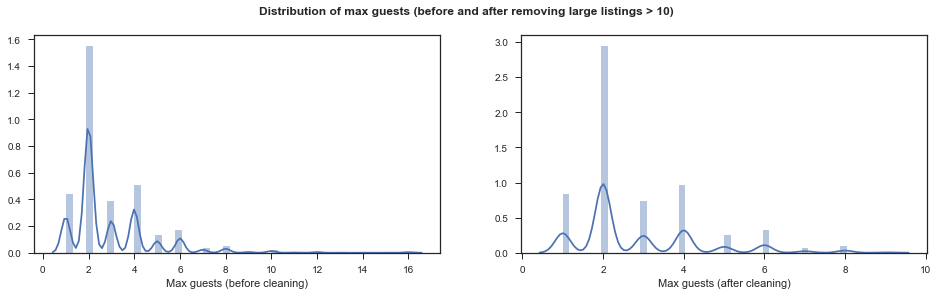

In [24]:

#Distribution of accomodation capacity
%matplotlib inline

fig, axs = plt.subplots(ncols=2, figsize=(16, 4))
fig.suptitle('Distribution of max guests (before and after removing large listings > 10)', weight='bold', fontsize=12)

# Before cleaning
x_axis=df['accommodates'].dropna()
sns.distplot(pd.Series(x_axis, name='Max guests (before cleaning)'), ax=axs[0])

# Remove where price > 1000
df=df[df['accommodates']<10]
print("Dataset has {} rows, {} columns.".format(*df.shape))

#After cleaning
x_axis=df['accommodates'].dropna()
sns.distplot(pd.Series(x_axis, name='Max guests (after cleaning)'), ax=axs[1]);

#### Create derived variables 

1. persons per bathroom
2. guests as a proportion fo capacity


In [25]:
# Create a bathrooms per guest variable 
df['ppl_bath']=df['bathrooms']/df['guests_included']
df['guest_prop'] = df['guests_included']/df['accommodates']

#### Aggregating variable values 
1. reduce dimensionality 
2. convert noise in to signal

##### Property Types 

In [26]:
df['property_type'].value_counts(normalize=True).head(20)

Apartment             0.824799
House                 0.073188
Townhouse             0.031133
Loft                  0.029791
Condominium           0.017901
Serviced apartment    0.005717
Guest suite           0.004563
Other                 0.003462
Bed and breakfast     0.002067
Resort                0.001691
Boutique hotel        0.001449
Guesthouse            0.000939
Hostel                0.000913
Hotel                 0.000537
Bungalow              0.000537
Villa                 0.000376
Tiny house            0.000242
Aparthotel            0.000161
Cottage               0.000107
Nature lodge          0.000081
Name: property_type, dtype: float64

I consolidated the property types with less than 1% representation into the other category 

In [27]:
#select types less than 1 percent for aggregation
var = df.property_type.value_counts(normalize=True)
rename =var[var < 0.009].index

df['property_type'].loc[df['property_type'].isin(rename)] = 'Other'

/Users/admin/anaconda3/envs/dsi/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


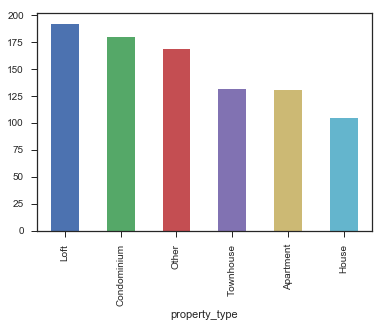

In [28]:
#
df.groupby('property_type')['price'].mean(
).sort_values(ascending=False)[:10].plot(kind='bar');

##### Lofts seem to be the most expensive rentals on average

#### Bed Types

In [29]:
df['bed_type'].value_counts(normalize=True).head(20)

Real Bed         0.976704
Futon            0.008884
Pull-out Sofa    0.007354
Airbed           0.004992
Couch            0.002067
Name: bed_type, dtype: float64

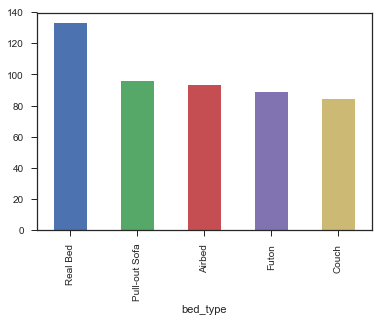

In [30]:
df.groupby('bed_type')['price'].mean(
).sort_values(ascending=False)[:10].plot(kind='bar');

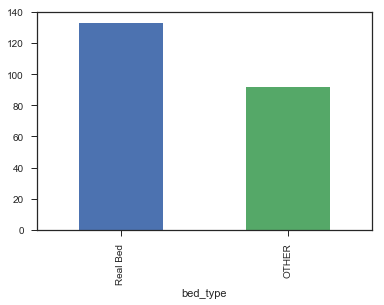

In [31]:
#bed or not bed?
df['bed_type'] = [type_ if type_ in ['Real Bed']
                      else "OTHER" for type_ in df['bed_type']]

df.groupby('bed_type')['price'].mean(
).sort_values(ascending=False)[:10].plot(kind='bar');

### Calculation of yield

In [32]:
#http://commissions.sfplanning.org/cpcpackets/2014-001033PCA.pdf & https://www.inc.com/sonya-mann/airbnb-nightmare-experiences.html

avg_length_of_stay = 6.4
review_rate = 0.75
df['price'] = df['price'] + df['cleaning_fee']
df['bnb_yield'] = avg_length_of_stay * df['price'] * (df['reviews_per_month'] / review_rate) * 12
df.drop(['cleaning_fee'],axis=1,inplace=True)
print("The mean yield is $ {}".format(df.bnb_yield.mean()))
print("The mean price is $ {}".format(df.price.mean()))

The mean yield is $ 24159.42116242619
The mean price is $ 178.6024154589372


/Users/admin/anaconda3/envs/dsi/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


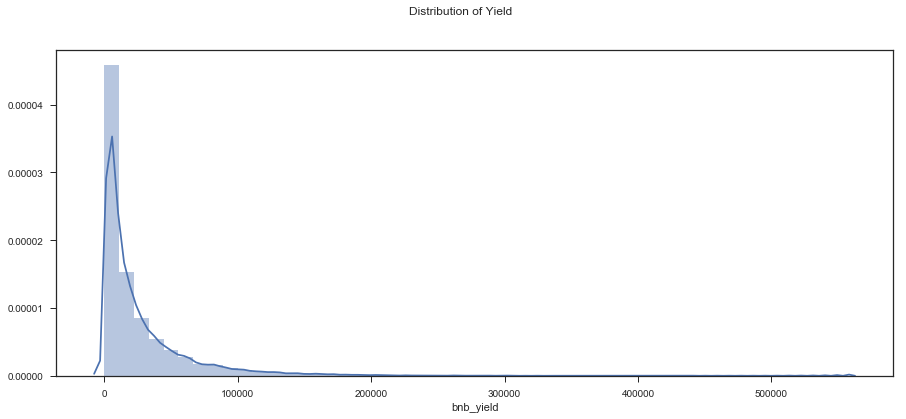

In [33]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(15,6))
fig.suptitle('Distribution of Yield')
x_axis = df['bnb_yield'].dropna()
x = pd.Series(x_axis, name=x_axis.name)
ax = sns.distplot(x)

In [34]:
df.bnb_yield.describe()

count     37260.000000
mean      24159.421162
std       35932.927372
min           0.000000
25%        3072.000000
50%       10680.320000
75%       29922.560000
max      555008.000000
Name: bnb_yield, dtype: float64

In [35]:
# assign class labels to yield
def map_labels(bnb_yield):
    if bnb_yield >= df["bnb_yield"].quantile(.90):
        return '1st'
    elif (bnb_yield >= df["bnb_yield"].quantile(.50)):
        return '2nd'
    elif (bnb_yield >= df["bnb_yield"].quantile(.10)):
        return '3rd'
    elif (bnb_yield >= 0):
        return '4th'
    else :
        return 'Error'
       
df["tier"] = df["bnb_yield"].map(map_labels)

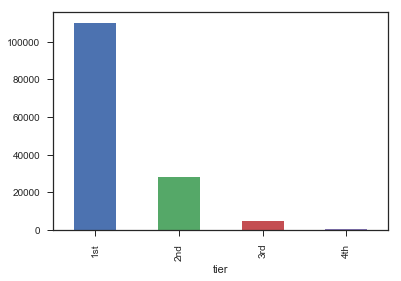

In [36]:
df.groupby('tier')['bnb_yield'].mean(
).sort_values(ascending=False).plot(kind='bar');

In [37]:
# assign class labelsby price
def map_labels(price):
    if price > df["price"].quantile(.75):
        return '1st'
    elif (price > df["price"].quantile(.50)):
        return '2nd'
    elif (price > df["price"].quantile(.25)):
        return '3rd'
    elif (price >= 0):
        return '4th'
    else :
        return 'Error'
       
df['tier_price'] = df["price"].map(map_labels)

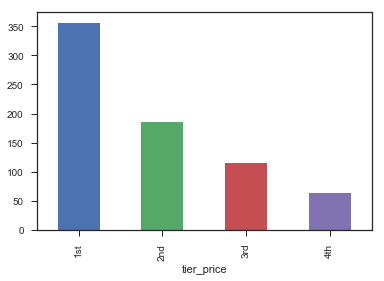

In [38]:
df.groupby('tier_price')['price'].mean(
).sort_values(ascending=False).plot(kind='bar');

### Time based Variables
#### Calculating the time a host has been active 

In [39]:
from datetime import datetime
from dateutil.parser import parse
from datetime import timedelta

In [40]:
df['host_since'] = pd.to_datetime(df['host_since'])

In [42]:
df['DateDiffHostSince'] = np.round((datetime.today() - df.host_since)/ np.timedelta64(1, 'D'),0)

In [43]:
df['DateDiffHostSince'].value_counts(normalize=True).tail(10)

3250.0    0.000027
3300.0    0.000027
2908.0    0.000027
3106.0    0.000027
3509.0    0.000027
3117.0    0.000027
3567.0    0.000027
2955.0    0.000027
3216.0    0.000027
3381.0    0.000027
Name: DateDiffHostSince, dtype: float64

### Geo-Spatial Analysis


#### Mapping distance to metro stations 

In [44]:
df_transit.head(5)


,Line,Station Name,Station Latitude,Station Longitude,Route1,Route2,Route3,Route4,Route5,Route6,Route7,Route8,Route9,Route10,Route11,Entrance Type,Entry,Exit Only,Vending,Staffing,Staff Hours,ADA,ADA Notes,Free Crossover,North South Street,East West Street,Corner,Entrance Latitude,Entrance Longitude,Station Location,Entrance Location
Division,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
BMT,4 Avenue,25th St,40.660397,-73.998091,R,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Stair,YES,NaN,YES,FULL,NaN,False,NaN,False,4th Ave,25th St,SE,40.660323,-73.997952,"(40.660397, -73.998091)","(40.660323, -73.997952)"
BMT,4 Avenue,25th St,40.660397,-73.998091,R,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Stair,YES,NaN,YES,NONE,NaN,False,NaN,False,4th Ave,25th St,SW,40.660489,-73.998220,"(40.660397, -73.998091)","(40.660489, -73.998220)"
BMT,4 Avenue,36th St,40.655144,-74.003549,N,R,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Stair,YES,NaN,YES,FULL,NaN,False,NaN,True,4th Ave,36th St,NW,40.654490,-74.004499,"(40.655144, -74.003549)","(40.654490, -74.004499)"
BMT,4 Avenue,36th St,40.655144,-74.003549,N,R,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Stair,YES,NaN,YES,FULL,NaN,False,NaN,True,4th Ave,36th St,NE,40.654365,-74.004113,"(40.655144, -74.003549)","(40.654365, -74.004113)"
BMT,4 Avenue,36th St,40.655144,-74.003549,N,R,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Stair,YES,NaN,YES,FULL,NaN,False,NaN,True,4th Ave,36th St,NW,40.654676,-74.004306,"(40.655144, -74.003549)","(40.654676, -74.004306)"


In [45]:
df_transit['Location']=list(zip(df_transit['Entrance Latitude'],df_transit['Entrance Longitude']))

In [46]:
# getting the unique station locations
df_transit.drop_duplicates(['Location'], keep='last',inplace=True)

In [47]:
df['Location']=list(zip(df['latitude'],df['longitude']))

stations =df_transit['Location'].dropna()

In [49]:
#Modified from  group assignment 3  
def dist_metro(input_location):
    distances=[]
    for key,val in stations.items():
        metro_distance=haversine(val, input_location)
        distances+=[metro_distance]
    return min(distances)
        

In [50]:
df['dist_transit']=df['Location'].map(dist_metro)

In [51]:
df['dist_transit'].describe()

count    37260.000000
mean         0.408036
std          0.700836
min          0.000912
25%          0.166522
50%          0.278352
75%          0.431180
max         21.780943
Name: dist_transit, dtype: float64

In [55]:
#save a pickle file for subsequnt use 
df.to_pickle('./data/airbnbNYCclean.pkl')